# Overview of Scenario
***
The following demonstrations will detect fraudulent labels by using a copyrighted image as a base target image.
The notebook will display images of labels that the deep learning one shot system selects as being fraudulent. Then the notebook will display images of labels that the system selects as being non-fradulent.

* First: Configure the deep learning model
* Second: Show which is the target beer label image
* Third: Show which images the fraud detection system selects as fraudulent
* Fourth: Show which images the fraud detection system selects as non-fraudulent

# Configure the deep learning model
***
This section of the notebook configures, and creates the deep learning model needed for the label fraud detection process.

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from scipy.spatial import distance as dist
import cv2
from numpy.random import seed
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import os
import glob
import json
import time


In [20]:

#Jeff's change
labelImages_dir = os.environ['MLDIR'] + "/TestData"
#labelImages_dir = "."   # Needed when in AWS, above needs to be commented out

seed(200)
tf.compat.v1.random.set_random_seed(1000)

x = np.zeros((2, 224, 224, 3))
        
def ReadJsonData(FileName):
    data = {}
    with open(FileName, 'r') as inpfile:
        data = json.load(inpfile)
        
    return data

img_shape = (224, 224, 3)
l2_reg = 0

def GenerateModelLinear(target_image_file_name):


    # Create the Deep Learning Model to detect fraudulent labels
    # Layer 1
    model_1 = Sequential()
    model_1.add(Conv2D(96, (11, 11), input_shape=img_shape, padding='same', kernel_regularizer=l2(l2_reg)))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2 
    model_1.add(Conv2D(256, (5, 5), padding='same'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Load the validation image, or target image
    subject01 = Image.open(target_image_file_name)

    # Load in input image
    subject02 = Image.open(target_image_file_name)

    # Normalize the input images
    subject01 = subject01.convert('RGB')
    
    subject02 = subject02.convert('RGB')
    subj01 = subject01.resize((224, 224))
    subj02 = subject02.resize((224, 224))
    subj01_a = np.array(subj01)
    subj02_a = np.array(subj02)

    #Here's where we do some voodoo
    x[0] = subj01_a
    x[1] = subj02_a
    x_out_1 = model_1.predict(x[0:2])
    x_out_1_r = np.ravel(x_out_1[0])
    x_out_2_r = np.ravel(x_out_1[1])
    print('linear shape = ' + str(len(x_out_2_r)))

    bin_group = 20
    max_histo_level = int(x_out_1_r.max()/bin_group + 1)*bin_group
    num_bins = 2*max_histo_level
    be_l, hist_l = np.histogram(x_out_1_r, bins=num_bins, range=[0.0, max_histo_level], density = True)
    
    #2 lines below - Debugging purposes
    #plt.bar(hist_l[1:-1], be_l[1:])
    #plt.show()

    # Calculate the
    be_h, hist_h = np.histogram(x_out_2_r, bins=num_bins, range=[0.0, max_histo_level], density = True)

    cor02 = np.dot(be_h[1:], be_l[1:])
    cor02 = sum(np.abs(be_l[1:] - be_h[1:]))
    
    return model_1, be_l, cor01, similar_diff, num_bins, max_histo_level


In [51]:
def GenreateModelArt(target_image_file_name):
    # Create the Deep Learning Model to detect fraudulent labels
    # Layer 1
    label_model = Sequential()
    label_model.add(Conv2D(96, (11, 11), input_shape=img_shape, padding='same', kernel_regularizer=l2(l2_reg)))
    label_model.add(BatchNormalization())
    label_model.add(Activation('relu'))
    label_model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2 
    label_model.add(Conv2D(256, (5, 5), padding='same'))
    label_model.add(BatchNormalization())
    label_model.add(Activation('relu'))
    label_model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3
    label_model.add(ZeroPadding2D((1, 1)))
    label_model.add(Conv2D(512, (3, 3), padding='same'))
    label_model.add(BatchNormalization()) 
    label_model.add(Activation('relu'))
    label_model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4
    label_model.add(ZeroPadding2D((1, 1)))
    label_model.add(Conv2D(1024, (3, 3), padding='same')) 
    label_model.add(BatchNormalization())
    label_model.add(Activation('relu'))
    # Layer 5
    label_model.add(ZeroPadding2D((1, 1)))
    label_model.add(Conv2D(1024, (3, 3), padding='same'))
    label_model.add(BatchNormalization())
    label_model.add(Activation('relu'))
    label_model.add(MaxPooling2D(pool_size=(2, 2)))

    # Load the validation image, or target image
    subject01 = Image.open(target_image_file_name)

    # Load in input image
    #subject02 = Image.open(mypath + 'test8.png')
    subject02 = Image.open(target_image_file_name)

    # Normalize the input images
    subject01 = subject01.convert('RGB')
    subject02 = subject02.convert('RGB')
    subj01 = subject01.resize((224, 224))
    subj02 = subject02.resize((224, 224))
    subj01_a = np.array(subj01)
    subj02_a = np.array(subj02)

    x = np.zeros((2, 224, 224, 3))

    # Here's where we do some voodoo
    x[0] = subj01_a
    x[1] = subj02_a
    x_out_1 = label_model.predict(x[0:2])
    x_out_1_only = np.ravel(x_out_1[0])
    x_out_2_r = np.ravel(x_out_1[1])
    print('shape = ' + str(len(x_out_2_r)))

    bin_group = 5
    max_histo_level = 40
    num_bins = 200

    # Calculate the histogram of target label

    #plt.plot(x_out_1_r)
    #plt.show()
    be_l, hist_l = np.histogram(x_out_1_only, bins=num_bins, range=[0, max_histo_level], density = True)
    #plt.bar(hist_l[1:-1], be_l[1:])
    #plt.show()

    be_h, hist_h = np.histogram(x_out_2_r, bins=num_bins, range=[0, max_histo_level], density = True)

    cor01 = np.dot(be_l[:], be_l[:])/num_bins
    similar_diff = 0.017
    similar_diff = 5.3/0.6
    similar_diff = 12.4/0.6
    cor02 = dist.chebyshev(be_l[:], be_h[:])

    return label_model, be_l, cor01, similar_diff, x_out_1_only


# Target Image

The target image represents the company's copyrighted image that we will be used to determine fraudulent images.  This is a registered trademark and all other images will be compared against it:

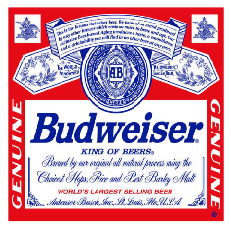

In [52]:
seed(200)
tf.compat.v1.random.set_random_seed(1000)

ConfigJson = {}
ConfigJson = ReadJsonData('FraudLabelConfig.json')
ModelName = ConfigJson['model_name']
#ImagePathName = labelImages_dir
ImagePathName = labelImages_dir + '/' + ConfigJson['target_directory'] + '/'
PercentThres = float(ConfigJson['scale_factor_for_threshold'])
#TargetImageFileName = labelImages_dir + ConfigJson['target_image_file_name']
TargetImageFileName = ImagePathName + ConfigJson['target_image_file_name']
target_image_file_name = TargetImageFileName
target_image= Image.open(TargetImageFileName)
subject02 = target_image.convert('RGB')
subj02 = subject02.resize((224, 224))
subj02_a = np.array(subj02)
plt.imshow(subj02_a)
plt.axis('off')
plt.show()

# Detected Fradulent Labels:
***
From the constructed dataset, the fraud detection system now will detect which labels are fraudulent.

In [53]:

def DisplayFraudulentLabelsLinear(mypath, percent_thres, model_1, be_l, cor01, similar_diff, num_bins, 
                                  max_histo_level, target_image_file_name):

    file_list = []
    file_name_list = []
    for filename in glob.glob(mypath + '*.jpg'):
        
        if filename in target_image_file_name:
            continue
        else:
            file_list.append(filename)

    similar_diff = 0.1
    img_list = []
    
    imgTarget = Image.open(TargetImageFileName)
    
    for fn in file_list:
        # Load test beer label image
        subject02 = Image.open(fn)
    
        # Normalize beer label image
        subject02 = subject02.convert('RGB')
        subj02 = subject02.resize((224, 224))
        subj02_a = np.array(subj02)
        save_0 = subj02_a[:,:,0]
        save_1 = subj02_a[:,:,1]
        x[0] = subj02_a

        # Process normalized beer label through model to generate feature vectors
        x_out_2 = model_1.predict(x[0:1])
        x_out_2_r = np.ravel(x_out_2[0])
    
        # Generate histogram, and correlation product to determine if the label is fraudulent
        be_h, hist_h = np.histogram(x_out_2_r, bins=num_bins, range=[0.0, max_histo_level], density = True)
        cor02 = sum(np.abs(be_l[1:]- be_h[1:]))
        #cor02 = dist.cheyshev(be_l[1:], be_h[1:])
        # Threshold the correlation product to determine fraudulence
        if(cor02 < similar_diff*percent_thres):
            img_list.append(subj02_a)
            file_name_list.append(fn)

    # Plot the fraudulent beer labels
    #print(len(img_list))
    num_figs = 5
    num_blocks = int(len(img_list)/num_figs)
    index = 0
    for kk in range(num_blocks):
        (a1, a2) = plt.subplots(1,5, figsize=(16, 16))
        for ii in range(5):
            a2[ii].imshow(img_list[index])
            a2[ii].axis('off')
            index += 1
        plt.show()
    
    left_over = len(img_list)%num_figs
    if(left_over > 1):
        (a1, a2) = plt.subplots(1,left_over, figsize=(10, 10))
        for ii in range(left_over):
            a2[ii].imshow(img_list[index])
            a2[ii].axis('off')
            index += 1
        plt.show()
    elif(left_over == 1):
        plt.subplots(1,1, figsize=(10,10))
        plt.imshow(img_list[index])
        plt.axis('off')
        plt.show()
        
    return file_name_list

shape = 262144
11.263333333333335
file_name = /Users/jkim/ML_FraudDetections/TTB/TestData/labelImages/Screen Shot 2019-12-14 at 8.33.14 AM.jpg
12.182399
file_name = /Users/jkim/ML_FraudDetections/TTB/TestData/labelImages/Screen Shot 2019-12-14 at 8.34.45 AM.jpg
18.620485
file_name = /Users/jkim/ML_FraudDetections/TTB/TestData/labelImages/Screen Shot 2019-12-15 at 8.37.31 AM.jpg
17.961578
file_name = /Users/jkim/ML_FraudDetections/TTB/TestData/labelImages/Screen Shot 2019-12-14 at 8.31.40 AM.jpg
14.546813
file_name = /Users/jkim/ML_FraudDetections/TTB/TestData/labelImages/Screen Shot 2019-12-14 at 8.35.30 AM.jpg
21.961988
file_name = /Users/jkim/ML_FraudDetections/TTB/TestData/labelImages/Screen Shot 2019-12-14 at 8.36.01 AM.jpg
14.462324
file_name = /Users/jkim/ML_FraudDetections/TTB/TestData/labelImages/test13.jpg
14.793977
file_name = /Users/jkim/ML_FraudDetections/TTB/TestData/labelImages/Screen Shot 2019-12-14 at 8.36.54 AM.jpg
17.755997
file_name = /Users/jkim/ML_FraudDetections/T

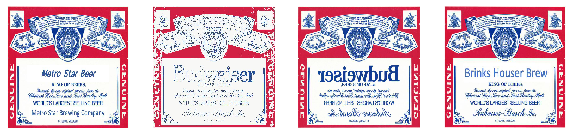

In [54]:

def DisplayFraudulentLabelsArt(mypath, percent_thres, label_model, be_l, cor01, 
                               similar_diff, target_image_file_name, x_only):

    bin_group = 5
    max_histo_level = 40
    num_bins = 200
    print(percent_thres*similar_diff)

    file_list = []    
#    for filename in glob.glob(mypath + '*.jpg'):
    for filename in glob.glob(mypath + '*.*'):
        
        if filename in target_image_file_name:
            continue
        else:
            file_list.append(filename)

    file_name_list = []
    img_list = []
    for fn in file_list:
        # Load test beer label image
        subject02 = Image.open(fn)
    
        # Normalize beer label image
        subject02 = subject02.convert('RGB')
        subj02 = subject02.resize((224, 224))
        subj02_a = np.array(subj02)
        save_0 = subj02_a[:,:,0]
        save_1 = subj02_a[:,:,1]
        x[0] = subj02_a
    
        x[0] = subj02_a
        x[1] = subj02_a
        x_out_1 = label_model.predict(x[0:2])
        x_out_1_r = np.ravel(x_out_1[0])
        x_out_2_r = np.ravel(x_out_1[1])
        print("file_name = " + str(fn))
        #plt.plot(x_out_2_r)
        #plt.show()

        # Generate histogram, and correlation product to determine if the label is fraudulent
        be_h, hist_h = np.histogram(x_out_2_r, bins=num_bins, range=[0.0, max_histo_level], density = True)
        diff = dist.chebyshev(x_out_2_r, x_only)
        print(diff)
        
        #print('diff = ' + str(diff) + ' similar_diff = ' + str(similar_diff))
        # Threshold the correlation product to determine fraudulence
        if(diff < similar_diff*percent_thres):
            img_list.append(subj02_a)
            file_name_list.append(fn)

    #print(str(len(img_list)))
    # Plot the fraudulent beer labels
    num_figs = 5
    num_blocks = int(len(img_list)/num_figs)
    index = 0
    for kk in range(num_blocks):
        (a1, a2) = plt.subplots(1,5, figsize=(16, 16))
        for ii in range(5):
            a2[ii].imshow(img_list[index])
            a2[ii].axis('off')
            index += 1
        plt.show()
    
    left_over = len(img_list)%num_figs

    if(left_over > 1):
        (a1, a2) = plt.subplots(1,left_over, figsize=(10, 10))
        for ii in range(left_over):
            a2[ii].imshow(img_list[index])
            a2[ii].axis('off')
            index += 1
        plt.show()
    elif(left_over == 1):
        plt.subplots(1,1, figsize=(10,10))
        plt.imshow(img_list[index])
        plt.axis('off')
        plt.show()
        
    return file_name_list
        
        


mypath = ImagePathName + '/'
if('art' in ModelName):
    [lb_model, be_l, cor01, similar_diff, x_only] = GenreateModelArt(TargetImageFileName)
    file_name_list = DisplayFraudulentLabelsArt(mypath, PercentThres, lb_model, be_l, cor01, 
                                                similar_diff, TargetImageFileName, x_only)
else:
    [lb_model, be_l, cor01, similar_diff, num_bins, max_histo_level] = GenerateModelLinear(TargetImageFileName)
    file_name_list = DisplayFraudulentLabelsLinear(mypath, PercentThres, lb_model, be_l, 
                                                   cor01, similar_diff, num_bins, max_histo_level, 
                                                   TargetImageFileName)

# Detected Non-Fraudulent Labels:
***
From the constructed dataset, the fraud detection system now will detect which labels are non-fraudulent.

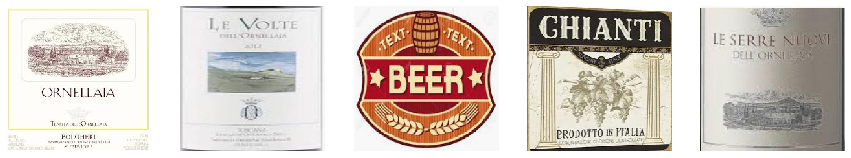

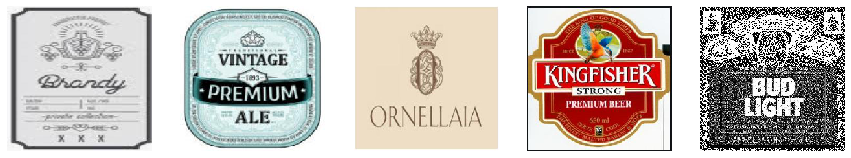

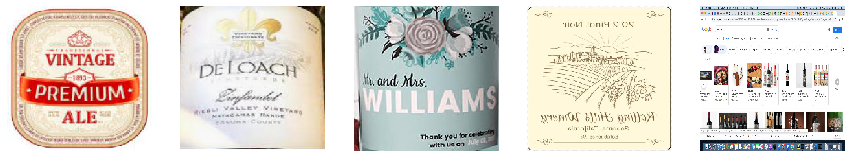

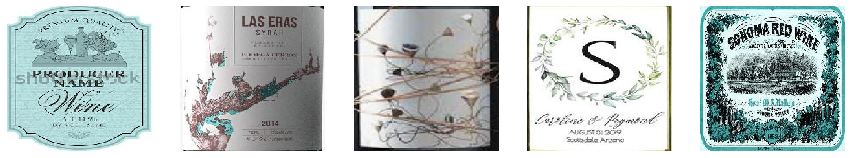

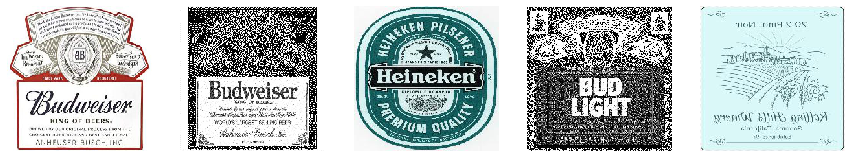

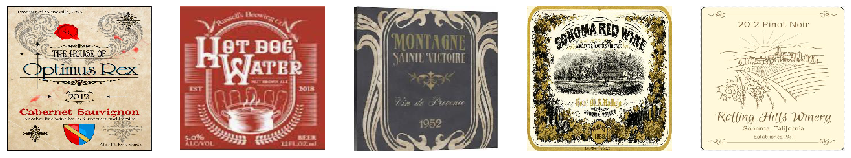

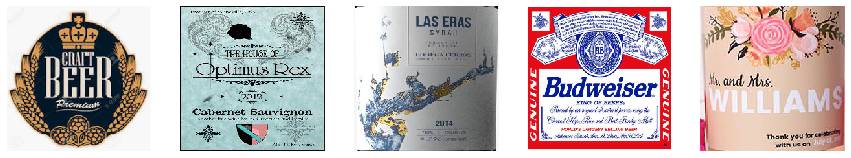

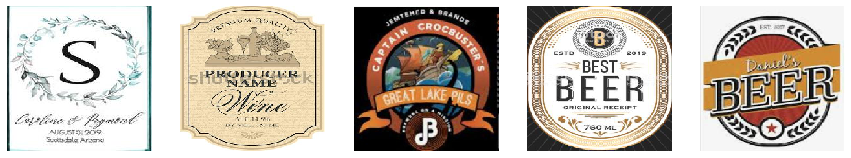

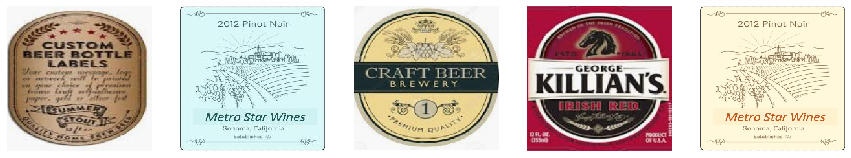

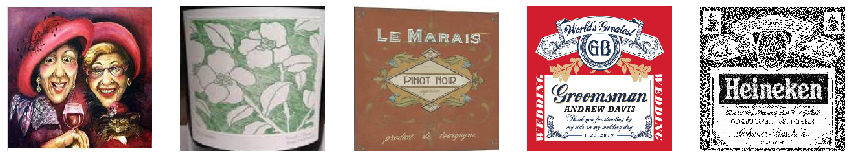

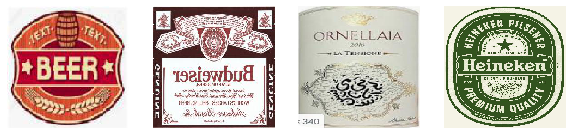

In [55]:
def DisplayNonFraudulentLabels(file_name_list):

    file_list = []
    num_figs = 5
    for filename in glob.glob(mypath + '*.jpg'):
        file_list.append(filename)
    
    img_list = []
    img_cnt = 0
    for fn in file_list:
        # Load input beer label image
        subject02 = Image.open(fn)
        # Normalize input beer labe image
        subject02 = subject02.convert('RGB')
        subj02 = subject02.resize((224, 224))
        subj02_a = np.array(subj02)

        if fn not in file_name_list:
            img_list.append(subj02_a)
            img_cnt += 1
    

        # Display non-fraudulent beer labels
        if(img_cnt >= num_figs):
            (a1, a2) = plt.subplots(1,5, figsize=(15,15))
            index = 0
            for ii in range(5):
                a2[ii].imshow(img_list[index])
                a2[ii].axis('off')
                index += 1
            plt.show()
            img_list = []
            img_cnt = 0

    if (img_cnt > 0):
        if(img_cnt > 1):
            index = 0
            (a1, a2) = plt.subplots(1,img_cnt, figsize=(10,10))
            for ii in range(img_cnt):
                a2[ii].imshow(img_list[index])
                a2[ii].axis('off')
                index += 1    
            plt.show()
        else:
            plt.subplots(1, 1, figsize=(5,5))
            plt.imshow(img_list[0])
            plt.axis('off')
            plt.show()


DisplayNonFraudulentLabels(file_name_list)

